# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Disabling warnings
import warnings
warnings.simplefilter("ignore")

### Importing the csv files

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape, test_df.shape

((891, 12), (418, 11))

# Data Analysis for training set

#### Checking null values

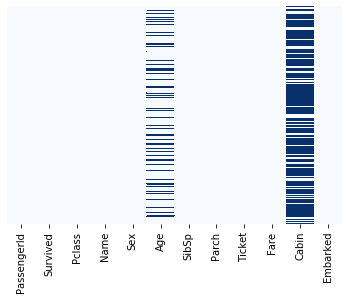

In [4]:
sns.heatmap(train_df.isnull(), cbar = False, yticklabels = False, cmap = 'Blues')

In [5]:
train_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

#### There are many null values for cabin and age as possible to see in the heat map and a few for embarked

In [6]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Since the null values for embarked are very low, let's just fill it with the most frequent value

In [7]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

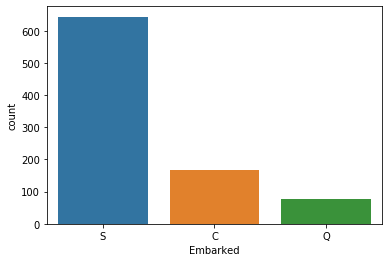

In [8]:
sns.countplot(x = 'Embarked', data = train_df)

In [9]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [10]:
print("%d null values for Embarked." % train_df['Embarked'].isnull().sum() )

0 null values for Embarked.


### Cabin null values

In [11]:
cabin_null_percentage = train_df['Cabin'].isnull().sum()*100 / train_df['Cabin'].shape[0]
cabin_null_percentage

77.10437710437711

#### 77% of the cabin values are null. Therefore, the best solution is to get rid of this column

In [12]:
train_df.drop(columns = ['Cabin'], inplace = True)

# For the age null values, I will create a machine learning model to try a better accuracy for this variable. However, I will train the model with the test and train data. Therefore, it has to be done after taking care of the null values from the test dataframe

In [13]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### I have dropped the cabin column from the train set, the same will be done in the test set

In [14]:
test_df.drop(columns = ['Cabin'], inplace = True)

### since we have only 1 missing value for fare, i will fill it with the mean fare value

In [15]:
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())

In [16]:
test_df.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
dtype: int64

## after that, we are ready to create the model to predict the age

In [17]:
age_df = train_df.append(test_df, sort = False)
age_df.drop(columns = ['Survived'], inplace = True)

In [18]:
age_train = age_df.dropna()
age_test = age_df[age_df['Age'].isna()]

In [19]:
age_train_id = age_train['PassengerId']
age_X_train = age_train.drop(columns = ['Age', 'Name', 'PassengerId', 'Ticket'])
age_y_train = age_train['Age']

In [20]:
age_test_id = age_test['PassengerId']
age_X_test = age_test.drop(columns = ['Age', 'Name', 'PassengerId', 'Ticket'])

### removing categorical variables

In [21]:
age_X_train = pd.get_dummies(age_X_train)
age_X_test = pd.get_dummies(age_X_test)

#### Dummy trap

In [22]:
age_X_train.drop(columns = ['Sex_female', 'Embarked_C'], inplace = True)
age_X_test.drop(columns = ['Sex_female', 'Embarked_C'], inplace = True)

### Predicting the age with RandomForest 

In [23]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(age_X_train, age_y_train)
age_pred = regressor.predict(age_X_test)

In [24]:
age_X_test['Age'] = age_pred
age_X_test['PassengerId'] = age_test_id
age_X_test.head()

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age,PassengerId
5,3,0,0,8.4583,1,1,0,28.451787,6
17,2,0,0,13.0000,1,0,1,32.606138,18
19,3,0,0,7.2250,0,0,0,29.298993,20
26,3,0,0,7.2250,1,0,0,27.929515,27
28,3,0,0,7.8792,0,1,0,21.235115,29


In [25]:
age_X_train['Age'] = age_y_train
age_X_train['PassengerId'] = age_train_id
age_X_train.head(10)

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age,PassengerId
0,3,1,0,7.2500,1,0,1,22.0,1
1,1,1,0,71.2833,0,0,0,38.0,2
2,3,0,0,7.9250,0,0,1,26.0,3
3,1,1,0,53.1000,0,0,1,35.0,4
4,3,0,0,8.0500,1,0,1,35.0,5
6,1,0,0,51.8625,1,0,1,54.0,7
7,3,3,1,21.0750,1,0,1,2.0,8
8,3,0,2,11.1333,0,0,1,27.0,9
9,2,1,0,30.0708,0,0,0,14.0,10
10,3,1,1,16.7000,0,0,1,4.0,11


In [26]:
test = age_X_train.append(age_X_test)
test.sort_values(by = 'PassengerId', ascending = True, inplace = True)
test.head(10)

,Pclass,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age,PassengerId
0,3,1,0,7.2500,1,0,1,22.000000,1
1,1,1,0,71.2833,0,0,0,38.000000,2
2,3,0,0,7.9250,0,0,1,26.000000,3
3,1,1,0,53.1000,0,0,1,35.000000,4
4,3,0,0,8.0500,1,0,1,35.000000,5
5,3,0,0,8.4583,1,1,0,28.451787,6
6,1,0,0,51.8625,1,0,1,54.000000,7
7,3,3,1,21.0750,1,0,1,2.000000,8
8,3,0,2,11.1333,0,0,1,27.000000,9
9,2,1,0,30.0708,0,0,0,14.000000,10


In [27]:
age_df['Ages pred'] = test['Age']
age_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ages pred
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,22.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,38.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,26.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,35.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,35.0


In [28]:
train_df_p = age_df.iloc[0:891, :] # train df are rows 0 - 890
test_df_p = age_df.iloc[891: , :] # test df are rows 891 - 1308

In [29]:
train_df_p['Survived'] = train_df['Survived']

In [30]:
train_df = train_df_p.drop(columns = ['Age'])
test_df = test_df_p.drop(columns = ['Age'])

In [31]:
train_df.columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Age', 'Survived']
test_df.columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Age']

# After that, we have filled all the missing values

In [32]:
train_df.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
Age            False
Survived       False
dtype: bool

In [33]:
test_df.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
Age            False
dtype: bool

## Data Analysis

In [34]:
correlation_frame = train_df.corr()

In [35]:
correlation_frame.iloc[:, [6]]

,Survived
PassengerId,-0.005007
Pclass,-0.338481
SibSp,-0.035322
Parch,0.081629
Fare,0.257307
Age,-0.077415
Survived,1.000000


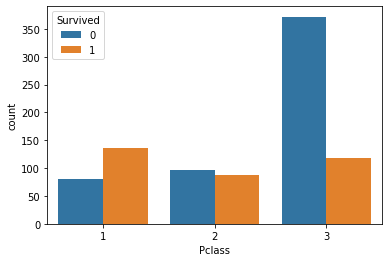

In [36]:
sns.countplot(x = 'Pclass', hue = 'Survived', data = train_df) # people from class 1 and 2 are more likely to survive

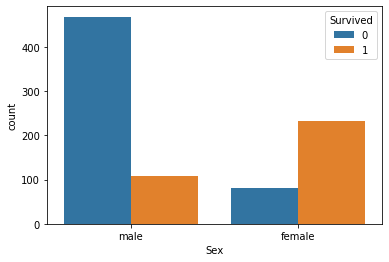

In [37]:
sns.countplot(x = 'Sex', hue = 'Survived', data = train_df) # Females are more likely to survive

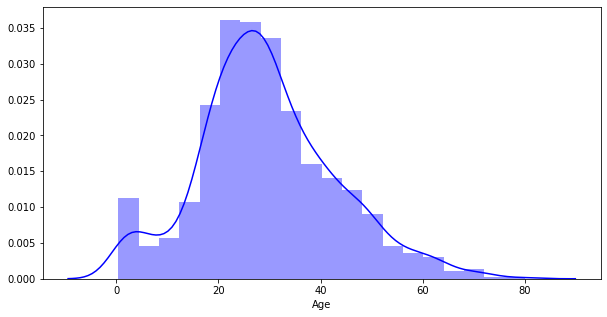

In [38]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['Age'], bins=20, color='b')

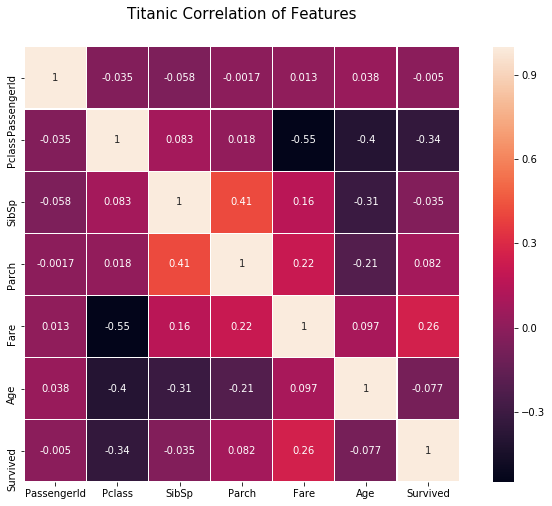

In [39]:
plt.figure(figsize=(12, 8))
plt.title('Titanic Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr(), linewidths=0.1, vmax=1.0, 
            square=True, linecolor='white', annot=True)

## Pre processing

In [40]:
train_df.drop(columns = ['PassengerId', 'Name', 'Ticket'], inplace = True)
test_id = test_df['PassengerId']
test_df.drop(columns = ['PassengerId', 'Name', 'Ticket'], inplace = True)

In [41]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [42]:
train_df.drop(columns = ['Sex_female', 'Embarked_C'], inplace = True)
test_df.drop(columns = ['Sex_female', 'Embarked_C'], inplace = True)
train_df.head()

,Pclass,SibSp,Parch,Fare,Age,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,1,0,7.2500,22.0,0,1,0,1
1,1,1,0,71.2833,38.0,1,0,0,0
2,3,0,0,7.9250,26.0,1,0,0,1
3,1,1,0,53.1000,35.0,1,0,0,1
4,3,0,0,8.0500,35.0,0,1,0,1


## Import dependencies

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [44]:
X = train_df.drop(columns = ['Survived'])
y = train_df['Survived']

#### Feature scaling

In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Split the train data. 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [47]:
class Model:
    def __init__(self, model):
        self.model = model
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.train()
    
    def model_name(self):
        model_name = type(self.model).__name__
        return model_name
    
    def cross_validation(self, cv = 5):
        print(f"Evaluate {self.model_name()} score by cross_validation...")
        CVS = cross_val_score(self.model, self.X, self.y, scoring = 'accuracy', cv = cv)
        print(CVS)
        print("="*60, "\nMean accuracy of cross-validation: ", CVS.mean())
    
    def train(self):
        print(f"Training {self.model_name()} Model...")
        self.model.fit(X_train, y_train)
        print("Model trained")
    
    def prediction(self, test_x = None, test = False):
        if test == False:
            y_pred = self.model.predict(self.X_test)
        else:
            y_pred = self.model.predict(test_x)
        return y_pred
    
    def accuracy(self):
        y_pred = self.prediction()
        y_test = self.y_test
        acc = accuracy_score(y_pred, y_test)
        print(f"{self.model_name()} Model accuracy: ", acc)

In [48]:
xgb = XGBClassifier()
xgb = Model(xgb)

Training XGBClassifier Model...
Model trained


In [49]:
xgb.cross_validation()

Evaluate XGBClassifier score by cross_validation...
[0.81005587 0.81564246 0.83146067 0.80898876 0.85310734]
Mean accuracy of cross-validation:  0.8238510213714724


In [50]:
xgb.accuracy()

XGBClassifier Model accuracy:  0.8383838383838383


In [51]:
svc = SVC()
svc = Model(svc)

Training SVC Model...
Model trained


In [52]:
svc.cross_validation()

Evaluate SVC score by cross_validation...
[0.84357542 0.82122905 0.81460674 0.79775281 0.8700565 ]
Mean accuracy of cross-validation:  0.8294441034021365


In [53]:
svc.accuracy()

SVC Model accuracy:  0.8114478114478114


In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',
                                    max_features = 5, max_depth = 10, min_samples_split = 4,
                                    min_samples_leaf = 2, bootstrap = True)
rfc = Model(rfc)

Training RandomForestClassifier Model...
Model trained


In [55]:
rfc.cross_validation()

Evaluate RandomForestClassifier score by cross_validation...
[0.81005587 0.82122905 0.86516854 0.81460674 0.86440678]
Mean accuracy of cross-validation:  0.8350933953522022


In [56]:
rfc.accuracy()

RandomForestClassifier Model accuracy:  0.8484848484848485


In [57]:
test_df.head() # needs scaling

,Pclass,SibSp,Parch,Fare,Age,Sex_male,Embarked_Q,Embarked_S
0,3,0,0,7.8292,34.5,1,1,0
1,3,1,0,7.0000,47.0,0,0,1
2,2,0,0,9.6875,62.0,1,1,0
3,3,0,0,8.6625,27.0,1,0,1
4,3,1,1,12.2875,22.0,0,0,1


In [58]:
test_df = scaler.transform(test_df)
test_X = test_df

In [59]:
x = XGBClassifier()
x.fit(X_train, y_train)
x_pred = x.predict(test_X)

In [60]:
xgb_pred = xgb.prediction(test_x = test_X, test = True)
svc_pred = svc.prediction(test_x = test_X, test = True)
rfc_pred = rfc.prediction(test_x = test_X, test = True)

In [72]:
xgb_output = pd.DataFrame({'PassengerId' : test_id, 'Survived':xgb_pred})
svc_output = pd.DataFrame({'PassengerId' : test_id, 'Survived':svc_pred})
rfc_output = pd.DataFrame({'PassengerId' : test_id, 'Survived':rfc_pred})

In [73]:
xgb_output.to_csv("xgb_output.csv", index = False)
svc_output.to_csv("svc_output.csv", index = False)
rfc_output.to_csv("rfc_output.csv", index = False)